In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Работа с FastText

In [0]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText
!sudo pip install ./fastText

In [0]:
import fasttext.util
fasttext.util.download_model('en', if_exists='strict')
fasttext.util.download_model('ru', if_exists='strict')

In [0]:
import fasttext
ft = fasttext.load_model('/content/drive/My Drive/fb_embeddings/cc.ru.300.bin')

In [0]:
ft = fasttext.util.reduce_model(ft, 100)

In [0]:
words = ft.get_words()

with open('/content/drive/My Drive/fb_embeddings/cc.ru.100.vec','w') as file_out:

    # the first line must contain number of total words and vector dimension
    file_out.write(str(len(words)) + " " + str(ft.get_dimension()) + "\n")

    # line by line, you append vectors to VEC file
    for w in words:
        v = ft.get_word_vector(w)
        vstr = ""
        for vi in v:
            vstr += " " + str(vi)
        try:
            file_out.write(w + vstr+'\n')
        except:
            pass

In [0]:
# path_to_zip = tf.keras.utils.get_file(
#     '/content/drive/My Drive/spa-eng.zip', origin='http://www.manythings.org/anki/rus-eng.zip',
#     )

path_to_file = "/content/drive/My Drive/rus-eng/rus.txt"

In [0]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = list(map(int, fin.readline().split()))
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

# Препроцессинг

In [0]:
def preprocess_sentence(w):
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z?.!,а-яА-Я]+", " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
en_sentence = u"May I borrow this book?"
ru_sentence = u"Можно одолжить эту книгу?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ru_sentence))

<start> May I borrow this book ? <end>
<start> Можно одолжить эту книгу ? <end>


In [0]:
def create_dataset_opus(source_path, target_path, num_examples):
  with open(source_path, encoding='UTF-8') as source_file:
    source_lines = source_file.read().strip().split('\n')
  with open(target_path, encoding='UTF-8') as target_file:
    target_lines = target_file.read().strip().split('\n')
  word_pairs = [[preprocess_sentence(l) for l in zip(source_lines, target_lines[:num_examples])]]

In [0]:
# 1. Чистка предложений
# 2. Возвращение пар в формате: [АНГЛИЙСКИЙ, РУССКИЙ]
def create_dataset(path, num_examples):
  lines = open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [9]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> Несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . Но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на Земле людей , ни один подходящи

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='', oov_token='<UNK>')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Ограничение размера датасета (опционально)

Тренировка на датасетах размерностью >150000 займет долгое время. Для ускорения возьмем меньше данных (качество перехода также уменьшится):

In [0]:
num_examples = 150000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [13]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

120000 120000 30000 30000


In [0]:
embeddings_index = load_vectors('/content/drive/My Drive/fb_embeddings/cc.ru.100.vec')

embedding_matrix = np.zeros((len(inp_lang.word_index) + 1, 100))
for word, i in inp_lang.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <start>
14 ----> мне
256 ----> кажется
9 ----> ,
27 ----> они
5008 ----> лгут
4 ----> .
3 ----> <end>
Target Language; index to word mapping
2 ----> <start>
5 ----> i
68 ----> think
40 ----> they
26 ----> re
368 ----> lying
4 ----> .
3 ----> <end>


### Создание датасета

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 256
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 12]))

## Написание кодировщика и декодера

Мы реализуем следующие элементы РНС:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)
    self.gru = tf.keras.layers.GRU(units=self.enc_units, return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
  def call(self, x):
    x = self.embedding(x)
    output, hs1 = self.gru(x)

    return output, hs1


In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_output, sample_hidden = encoder(example_input_batch)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 256)
Encoder Hidden state shape: (batch size, units) (64, 256)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [22]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 256)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
en_embeddings_index = load_vectors('/content/drive/My Drive/fb_embeddings/cc.en.100.vec')

en_embedding_matrix = np.zeros((len(targ_lang.word_index) + 1, 100))
for word, i in targ_lang.word_index.items():
    embedding_vector = en_embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, 100, weights=[en_embedding_matrix], trainable=False)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)

    return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 8754)


## Оптимизатор и функция потерь

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Сохранение весов модели

In [0]:
checkpoint_dir = '/content/drive/My Drive/training_checkpointss'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Обучение

In [0]:
@tf.function
def train_step(inp, targ):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [34]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # сохранение модели каждые две эпохи
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.9287
Epoch 1 Batch 100 Loss 2.8356
Epoch 1 Batch 200 Loss 2.6794
Epoch 1 Batch 300 Loss 2.5646
Epoch 1 Batch 400 Loss 2.5806
Epoch 1 Batch 500 Loss 2.3569
Epoch 1 Batch 600 Loss 2.3158
Epoch 1 Batch 700 Loss 2.2692
Epoch 1 Batch 800 Loss 2.1847
Epoch 1 Batch 900 Loss 2.2256
Epoch 1 Batch 1000 Loss 1.9793
Epoch 1 Batch 1100 Loss 1.9647
Epoch 1 Batch 1200 Loss 2.0239
Epoch 1 Batch 1300 Loss 1.9197
Epoch 1 Batch 1400 Loss 1.8574
Epoch 1 Batch 1500 Loss 1.9795
Epoch 1 Batch 1600 Loss 2.0273
Epoch 1 Batch 1700 Loss 1.9068
Epoch 1 Batch 1800 Loss 1.9165
Epoch 1 Loss 2.2450
Time taken for 1 epoch 190.44224643707275 sec

Epoch 2 Batch 0 Loss 1.7281
Epoch 2 Batch 100 Loss 1.6665
Epoch 2 Batch 200 Loss 1.7738
Epoch 2 Batch 300 Loss 1.6921
Epoch 2 Batch 400 Loss 1.5879
Epoch 2 Batch 500 Loss 1.8093
Epoch 2 Batch 600 Loss 1.6496
Epoch 2 Batch 700 Loss 1.6905
Epoch 2 Batch 800 Loss 1.6665
Epoch 2 Batch 900 Loss 1.6500
Epoch 2 Batch 1000 Loss 1.5784
Epoch 2 Batch 1100 Loss 1.5

KeyboardInterrupt: ignored

## Перевод

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] if i in inp_lang.word_index else inp_lang.word_index['<UNK>'] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  enc_out, enc_hidden = encoder(inputs)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# отриссовывание весов механизма внимания
def plot_attention_func(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence, plot_attention=True, return_translation=False):
  result, sentence, attention_plot = evaluate(sentence)

  if plot_attention:
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention_func(attention_plot, sentence.split(' '), result.split(' '))
  
  if not return_translation:
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
  return result

## Restore the latest checkpoint and test

In [31]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> О чем ты думаешь ? <end>
Predicted translation: why you you you you ? <end> 


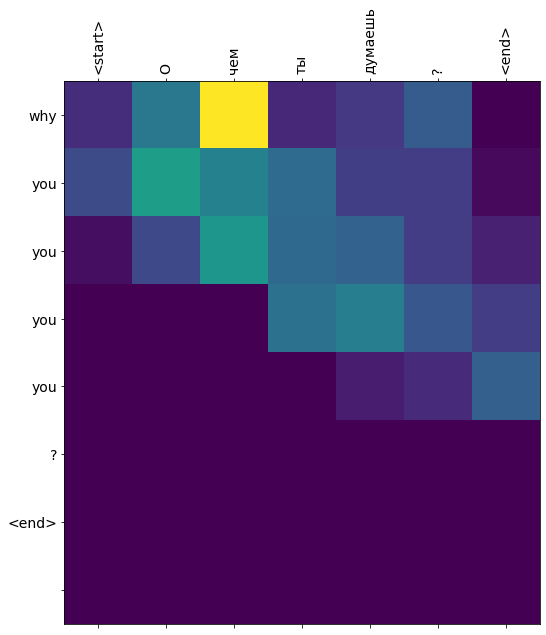

In [33]:
translate(u'О чем ты думаешь?')

Input: <start> Пошли домой <end>
Predicted translation: the to go . . <end> 


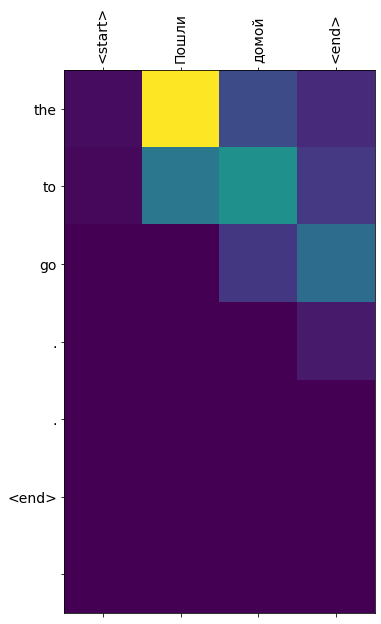

In [34]:
translate(u'Пошли домой')

In [0]:
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))

In [0]:
reverse_word_map_input = dict(map(reversed, inp_lang.word_index.items()))
reverse_word_map_target = dict(map(reversed, targ_lang.word_index.items()))
reverse_word_map_input[0] = ''
reverse_word_map_target[0] = ''

In [0]:
from nltk.translate.bleu_score import sentence_bleu
def calc_scores(dataset, only_get_example=False, example_idx=None):
  scores_bleu = []
  for idx, (input_sentence, target_sentence) in enumerate(dataset):
    if example_idx is not None and idx != example_idx:
      continue
    input_sentence = np.array(input_sentence[1:])
    target_sentence = np.array(target_sentence[1:])
    input_sentence = [x for x in input_sentence if x]
    target_sentence = [x for x in target_sentence if x]
    str_sentence_lst = [reverse_word_map_input[i] for i in input_sentence]
    target_sentence_optimal = [reverse_word_map_target[i] for i in target_sentence]
    str_sentence_lst = [x for x in str_sentence_lst  if x!='<end>' and x!='<UNK>']
    target_sentence_optimal = [x for x in target_sentence_optimal  if x!='<end>' and x!='<UNK>']
    plot_attention = False
    if only_get_example:
      plot_attention = True
    translation_model = translate(' '.join(str_sentence_lst[:-2]), plot_attention=plot_attention, return_translation=True)
    if only_get_example:
      print('Исходный текст: ', ' '.join(str_sentence_lst))
      print('Перевод модели:', translation_model)
      print('Правильный перевод: ', ' '.join(target_sentence_optimal))
      return
    target_sentence_model_prediction = translation_model[:-2].split(' ')
    score = sentence_bleu(target_sentence_optimal, target_sentence_model_prediction, weights=(0.33, 0.33, 0.33, 0))
    scores_bleu.append(score)
  return scores_blue

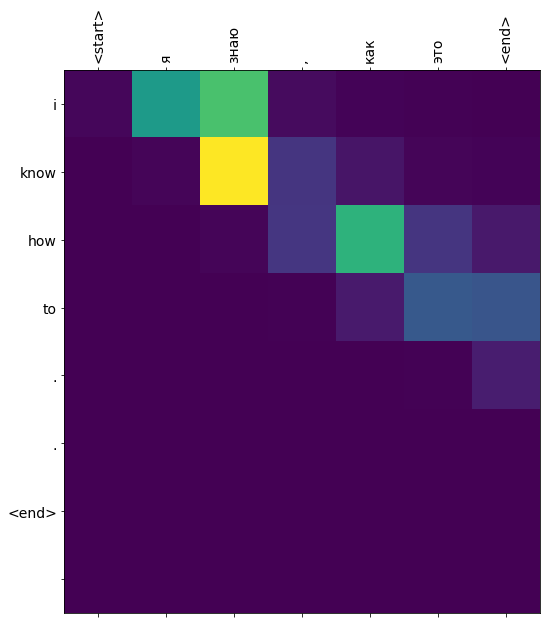

Исходный текст:  я знаю , как это трудно .
Перевод модели: i know how to . . <end> 
Правильный перевод:  i know how hard that is .


In [65]:
calc_scores(dataset_val, only_get_example=True)

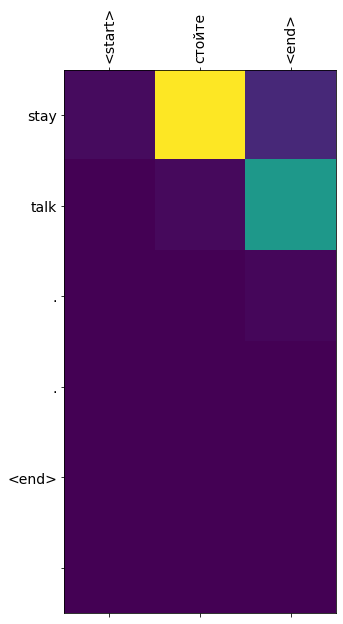

Исходный текст:  стойте спокойно .
Перевод модели: stay talk . . <end> 
Правильный перевод:  stand still .


In [67]:
calc_scores(dataset_val, only_get_example=True, example_idx=2)

# Среднее значение BLEU

In [68]:
print(np.mean(scores_bleu))

0.5380590578805233
